In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
from matplotlib import pyplot as plt
from geopy.geocoders import Nominatim
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.point import Point
import logging
import warnings
warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Проект/finalData.csv')
data = data.drop(['Unnamed: 0'], axis=1)#подтянулись лишние колонки

In [ ]:
def make_df_dtype(data):
    '''
    Создает датафрейм для анализа исходного фрейма по каждому признаку.
    Каждая строка соответствует столбцу исходного датафрейма и предоставляет информацию:
    - тип данных
    - количество уникальных значений
    - процент пропущенных значений

    Args:
        data (DataFrame): Датафремй для анализа

    Returns:
        df(DataFrame): Сформированный датафрейм
    '''

    cols, dtype_col, nunique, null_share = [], [], [], []
    for column in data:
        cols.append(column)

        this_dtype = data[column].dtype
        dtype_col.append(this_dtype)

        nunique.append(data[column].nunique())

        null_sum = data[column].isna().sum()
        null_to_len = null_sum / len(data[column])
        null_share.append(f'{null_to_len:.2%}')

    df = pd.DataFrame(list(zip(dtype_col,
                               nunique,
                              null_share)),
                      index=cols)
    df.columns=['dtype',
                'nunique',
               'null_share']

    return df


# Особенности данных

In [ ]:
data.shape

(23023, 14)

In [ ]:
make_df_dtype(data)

,dtype,nunique,null_share
Country,object,177,0.00%
City,object,23021,0.00%
AQI Value,int64,344,0.00%
AQI Category,object,6,0.00%
CO AQI Value,int64,34,0.00%
CO AQI Category,object,3,0.00%
Ozone AQI Value,int64,213,0.00%
Ozone AQI Category,object,5,0.00%
NO2 AQI Value,int64,59,0.00%
NO2 AQI Category,object,2,0.00%


In [ ]:
data.duplicated().any()

False

Отлично, у нас нет дублей. Пропуски есть только по странам - 10%.



---

Так как я планирую начать  линейной регрессии, то посмотрим на признаки, которые "наиболее линейно" связаны с целевой переменной - посмотрим на коэффициент корреляции Пирсона.  

$$
\text{corr}(X, Y)=\frac{\operatorname{cov}_{X Y}}{\sigma_X \sigma_Y}=\frac{\sum_{i=1}^n(X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^n(X_i - \bar{X})^2 \sum_{i=1}^n(Y_i - \bar{Y})^2}}
$$  

Пока будем расматривать только числовые признаки.

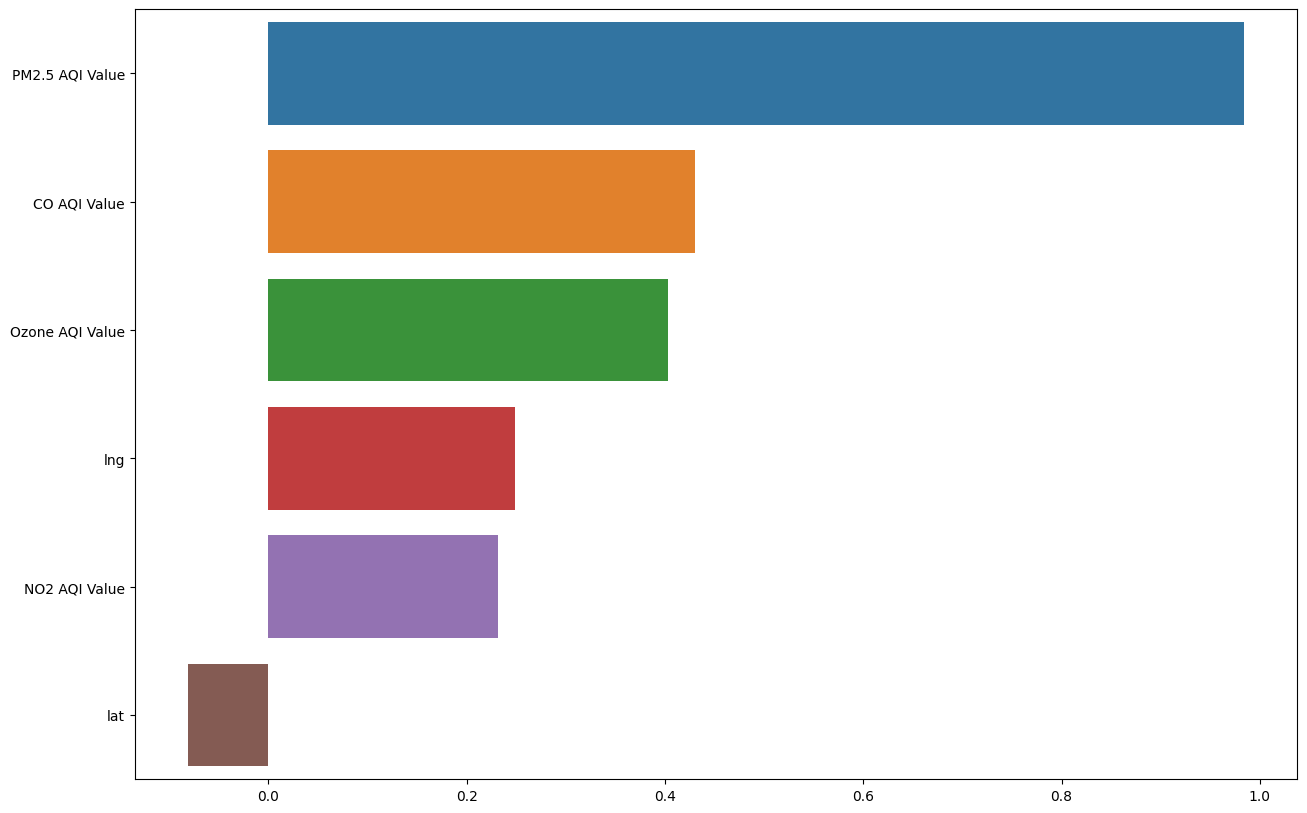

In [ ]:
numeric_data = data[data.columns.difference(['AQI Value'])].select_dtypes([np.number])
numeric_features = numeric_data.columns

correlations = data[numeric_features].corrwith(data['AQI Value']).sort_values(ascending=False)


plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

Посмотрим на первые 4 признака (не будем брать координаты). Для этого нарисуем график зависимости целевой переменной от каждого из признаков. На этом графике каждая точка соответсвует паре признак-таргет.

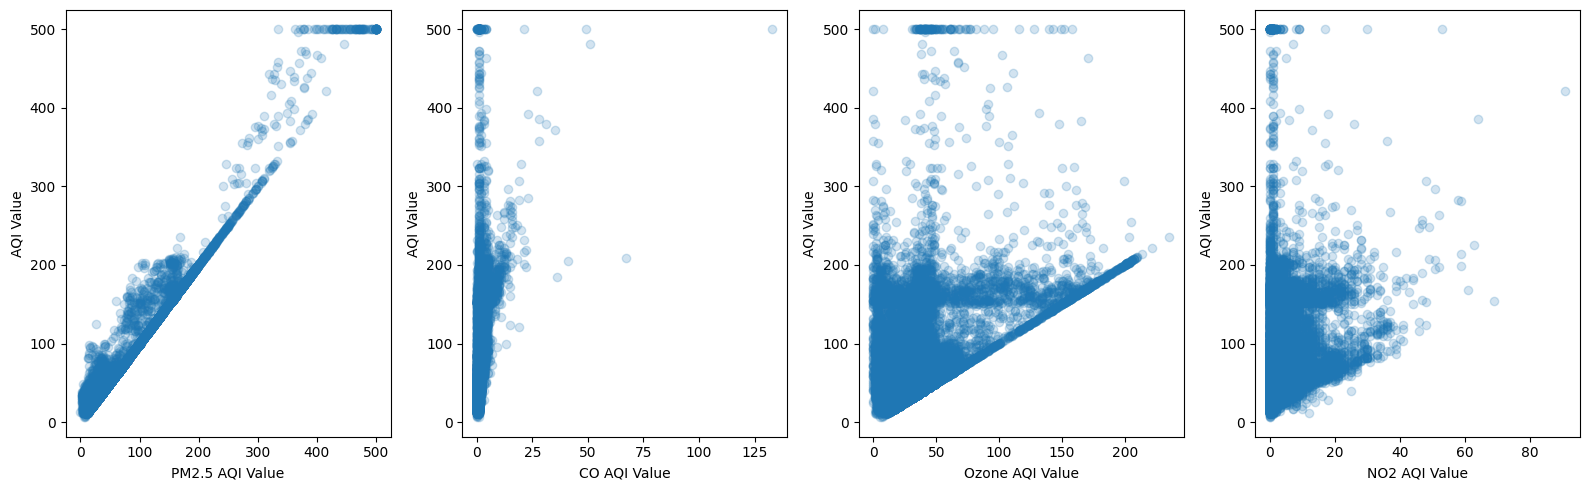

In [ ]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=4)
for i, feature in enumerate(["PM2.5 AQI Value", "CO AQI Value", "Ozone AQI Value", "NO2 AQI Value"]):
    axs[i].scatter(data[feature], data['AQI Value'], alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("AQI Value")
plt.tight_layout()

Между этими признаками определенно линейная связь. Особенно четкая с PM2.5 AQI Value.  
Посмотрим на попарное распределение этих признаков и окрасим их по категориям индекса качества воздуха.

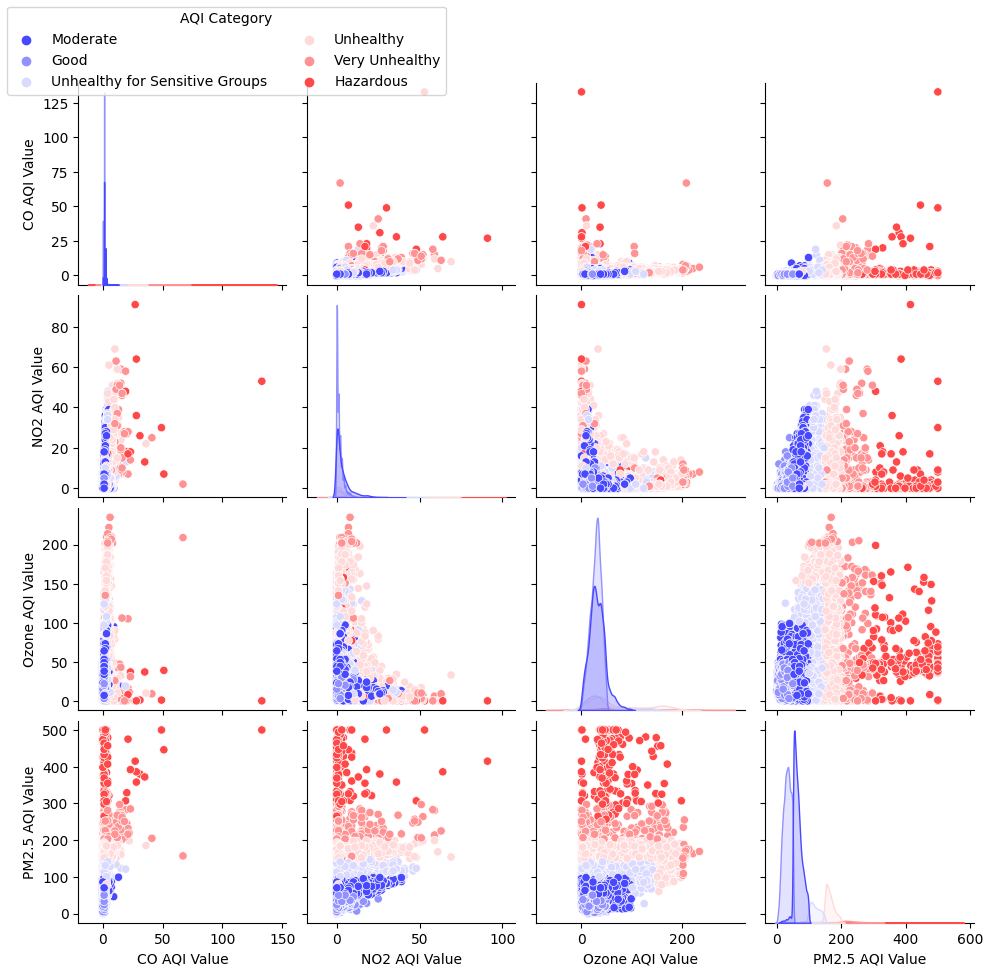

In [ ]:
data_copy = pd.concat([numeric_data.copy(), data["AQI Category"]], axis=1)
data_copy =data_copy.drop(["lat", 'lng'], axis=1)
g = sns.pairplot(data=data_copy, hue = "AQI Category", palette = 'bwr')
sns.move_legend(g, "upper left", ncol=2, frameon=True)
g.fig.subplots_adjust(top=0.92, bottom=0.08)
plt.show(g)

Основные статистики для вещественных и категориальных признаков

In [ ]:
data.describe()

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value,lat,lng
count,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000
mean,71.864831,1.369283,35.042349,3.082787,68.389176,28.530029,11.960019
std,56.055641,1.841570,27.994615,5.275645,54.761450,23.131357,68.924746
min,6.000000,0.000000,0.000000,0.000000,0.000000,-54.801900,-178.717035
25%,39.000000,1.000000,21.000000,0.000000,35.000000,14.845950,-45.380587
50%,55.000000,1.000000,30.000000,1.000000,54.000000,35.781900,12.190000
75%,79.000000,1.000000,40.000000,4.000000,78.000000,46.424700,72.266964
max,500.000000,133.000000,235.000000,91.000000,500.000000,76.406672,178.020649


In [ ]:
data.describe(include='object')

,Country,City,AQI Category,CO AQI Category,Ozone AQI Category,NO2 AQI Category,PM2.5 AQI Category
count,23023,23023,23023,23023,23023,23023,23023
unique,177,23021,6,3,5,2,6
top,United States,Jerusalem,Good,Good,Good,Good,Good
freq,2910,3,9785,23020,20701,23008,10051


Посмотрим есть ли повторения по городам. Если таковые имеются, то проверим какое количество строк для найденных дублей имеет разный город и таргет. В завиимости отт результата или удалим дубли, или усредним значение.

In [ ]:
data['City'].duplicated(keep=False).sum()

3

In [ ]:
dups = data[data.duplicated(subset=['City','AQI Value'], keep=False)]
dups.shape

(0, 14)

Получим, что дубли по городам имеют один и тот же таргет, соответсвенно их можно просто удалить.

In [ ]:
data = data.drop_duplicates(subset='City', keep="first")

Добавим новый признак - средне значение индекса качества воздуха по стране, до того как удалим выбросы.

In [ ]:
data["countryAverage"]=data["Country"].map(data.groupby("Country")["AQI Value"].mean())

Посмотрим на значения целевой переменной.

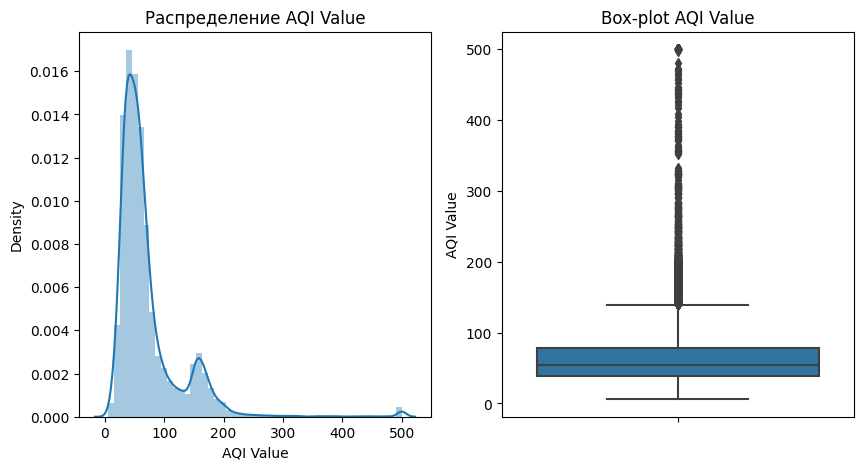

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Распределение AQI Value")
sns.distplot(data['AQI Value'])

plt.subplot(1,2,2)
plt.title("Box-plot AQI Value")
sns.boxplot(y=data['AQI Value'])

plt.show()

Судя по гистограмме, у нас есть примеры с нетипично большим значением индекса, что может помешать нам, если наша функция потерь будет слишком чувствительной к выбросам. Но просто так их удалять не стоит, необходимо понять, что дает такой выброси возможно значения индекса в конкретных странах действительно очень высоки.

Целевая переменная распределена неравномерно. Среднее значение 62 и 75% выборки входят в это значение. Но вот 15% имееют разброс от 86 до 500, что больше выглядит как выброс, о чем также говорит ящик с усами. Хотя с точки зрения области, стоит сначала оценить данные, в которых это значение первышается и посмотреть является ли оно выбросом или нет.

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category,lat,lng,countryAverage
9,Egypt,Qalyub,142,Unhealthy for Sensitive Groups,3,Good,89,Moderate,9,Good,142,Unhealthy for Sensitive Groups,30.178875,31.206436,102.052632
12,India,Radaur,158,Unhealthy,3,Good,139,Unhealthy for Sensitive Groups,1,Good,158,Unhealthy,30.043407,77.185444,153.829654
13,Pakistan,Radhan,158,Unhealthy,1,Good,50,Good,1,Good,158,Unhealthy,31.747590,75.281871,178.777409
16,India,Rajgir,154,Unhealthy,3,Good,100,Unhealthy for Sensitive Groups,2,Good,154,Unhealthy,25.029997,85.420737,153.829654
19,India,Phulabani,161,Unhealthy,2,Good,71,Moderate,0,Good,161,Unhealthy,20.507566,84.227311,153.829654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22975,Yemen,Lahij,152,Unhealthy,1,Good,44,Good,1,Good,152,Unhealthy,13.166667,44.583333,144.571429
22989,Mexico,Tlaltelulco,181,Unhealthy,3,Good,2,Good,11,Good,181,Unhealthy,19.275833,-98.193889,89.407095
22996,Nigeria,Hadejia,141,Unhealthy for Sensitive Groups,4,Good,42,Good,2,Good,141,Unhealthy for Sensitive Groups,12.452610,10.041893,100.524823
23015,China,Shaoguan,160,Unhealthy,3,Good,160,Unhealthy,1,Good,79,Moderate,24.801100,113.592700,127.420849


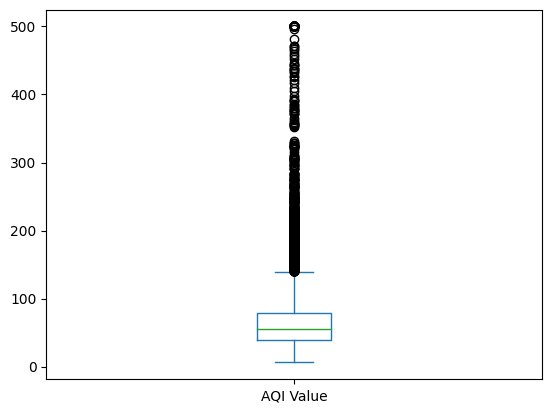

In [ ]:
_, bp = data['AQI Value'].plot.box(return_type='both')
outliers = [flier.get_ydata() for flier in bp["fliers"]][0]
data[data['AQI Value'].isin(outliers)]

Фильтр Хэмпеля:
функция, которая заменит на nan все значения, у которых разница с медианой больше, чем три медианных абсолютных отклонения. Посмотрим сколько выйдет таких значений.

In [ ]:
def hampel(vals_orig):
    vals = vals_orig.copy()
    difference = np.abs(vals.median()-vals)
    median_abs_deviation = difference.median()
    threshold = 3 * median_abs_deviation
    outlier_idx = difference > threshold
    vals[outlier_idx] = np.nan
    return(vals)

In [ ]:
hampel(data['AQI Value']).isna().sum()

3757

Это много, и скорее всего среди них есть показательные примеры. Получим соответствующую верхнюю границу и посмотрим все, что выходит за их рамки.

In [ ]:
upper_bound = data['AQI Value'].quantile(q=0.975)
data[(data['AQI Value'] > upper_bound)]

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category,lat,lng,countryAverage
43,India,Darbhanga,247,Very Unhealthy,3,Good,162,Unhealthy,1,Good,247,Very Unhealthy,26.170000,85.900000,153.829654
77,China,Hangzhou,203,Very Unhealthy,5,Good,203,Very Unhealthy,5,Good,151,Unhealthy,30.250000,120.167500,127.420849
178,India,Govindgarh,307,Hazardous,1,Good,45,Good,0,Good,307,Hazardous,24.378500,81.296400,153.829654
235,India,Afzalgarh,198,Unhealthy,4,Good,198,Unhealthy,3,Good,188,Unhealthy,29.356351,78.728774,153.829654
272,Pakistan,Bahawalnagar,500,Hazardous,1,Good,38,Good,1,Good,466,Hazardous,29.992800,73.253600,178.777409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22416,India,Sikandarabad,500,Hazardous,2,Good,42,Good,3,Good,500,Hazardous,17.433725,78.500683,153.829654
22614,China,Homei,204,Very Unhealthy,4,Good,204,Very Unhealthy,9,Good,156,Unhealthy,50.735044,7.102337,127.420849
22719,China,Xuchang,202,Very Unhealthy,4,Good,202,Very Unhealthy,3,Good,151,Unhealthy,34.147778,113.714722,127.420849
22766,Mexico,Tlalancaleca,355,Hazardous,4,Good,4,Good,17,Good,355,Hazardous,19.313037,-98.536537,89.407095


Удалим данные значения. Так как они очевидно превышают средние значения по стране.

In [ ]:
data.shape

(23021, 15)

In [ ]:
index_names = data[(data['AQI Value'] > upper_bound)].index
data.drop(index_names, inplace = True)

In [ ]:
data.shape

(22459, 15)

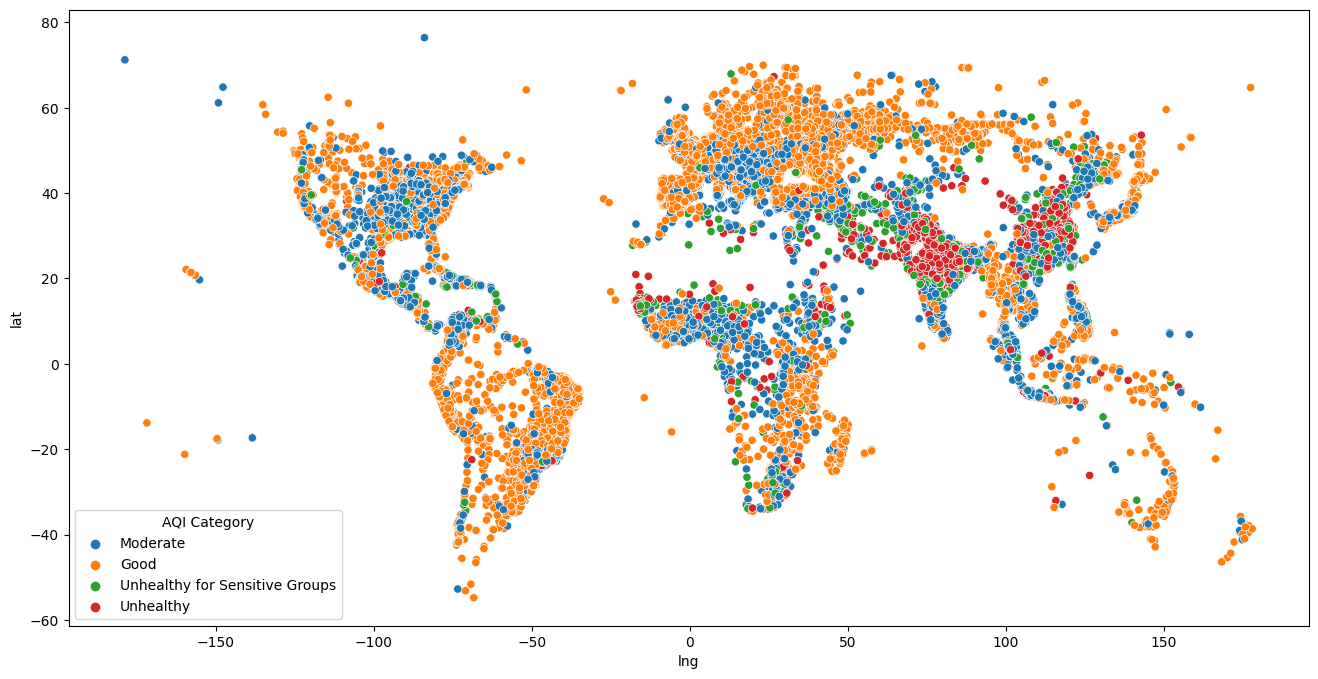

In [ ]:
plt.figure(figsize=(16, 8))
sns.scatterplot(data=data, x='lng', y='lat', hue='AQI Category')
plt.show()

Видим, что отстуствуют данные по восточной части РФ, Китай, Монголия, Северо-африканским странам (Алжир, Ливия, Египет). В остальном данные соответсвуют населяемым территориям (наприре Астралии и Бразилии, где нет данных по незаселенным местам).

Проверим нет ли отрицательных значений в наших данных (исключая колонки с координатами)

In [ ]:

for column in data[data.columns.difference(['lat','lng'])].select_dtypes(include=np.number):
    negative_values = data[data[column] < 0]

    if not negative_values.empty:
        print(f"Column '{column}' has negative values:")

        # Create a dictionary to store counts of negative values
        negative_counts = {}

        for index, value in negative_values.iterrows():
            value = value[column]
            if value in negative_counts:
                negative_counts[value] += 1
            else:
                negative_counts[value] = 1

        for value, count in negative_counts.items():
            print(f"Negative value {value} occurred {count} times")

Отлично, отрицательных значений нет. Посмотрим на наличие выбросов в других признаках: AQI Value, CO AQI Value, Ozone AQI Value, NO2 AQI Value, PM2.5 AQI Value

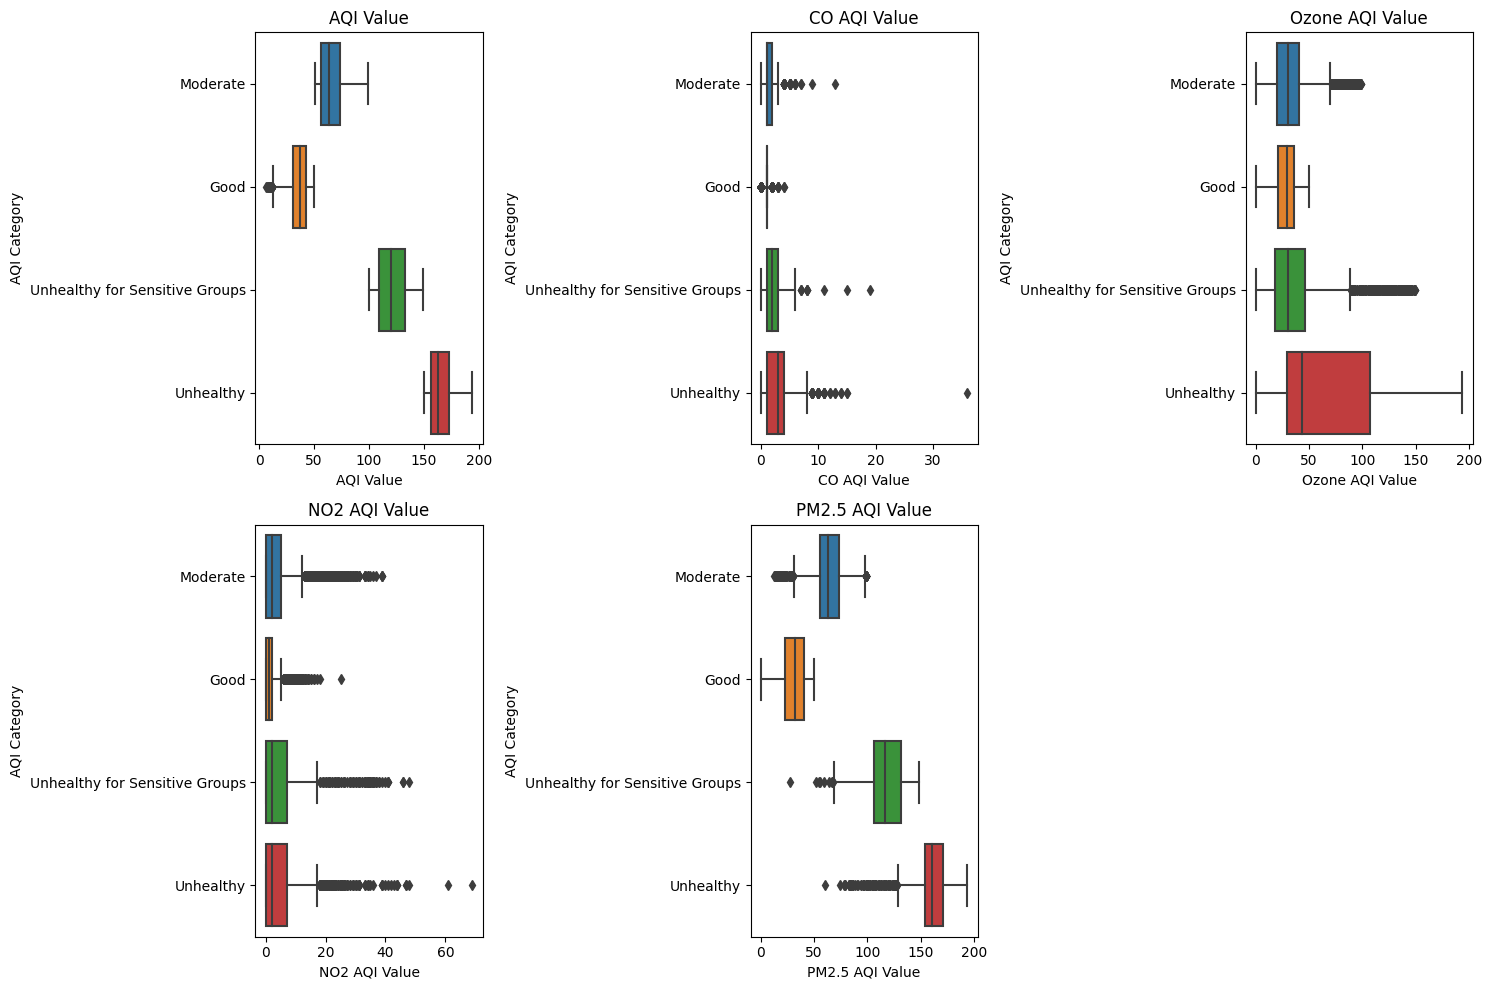

In [ ]:
col=[ 'AQI Value', 'CO AQI Value',
       'Ozone AQI Value','NO2 AQI Value', 'PM2.5 AQI Value']
fig = plt.figure(figsize=(15,10))

for i in range(len(col)):
    plt.subplot(2,3,i+1)
    plt.title(col[i])
    sns.boxplot(data=data,x=data[col[i]],y=data['AQI Category'])
plt.tight_layout()
plt.show()

Посчитаем количество выбросов используя квантильные значения

In [ ]:
Q1=data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR=Q3-Q1

In [ ]:
df_copy = data.select_dtypes(include=np.number)
((df_copy<(Q1-1.5*IQR))|(df_copy>(Q3+1.5*IQR))).sum()

AQI Value          2514
CO AQI Value       8093
Ozone AQI Value    1318
NO2 AQI Value      1563
PM2.5 AQI Value    2249
lat                 177
lng                   0
countryAverage     2424
dtype: int64

СО явно имеет выброс +50 даже по европейским меркам. NО2 хоть и выглядит как будто имеет выброс, но по табличным значениям все вполне неплохо. Хотя смущает, что по таблице все значения супер "мягкие" и доходят в среднем до 50, интересно посмотреть как они сочетаются вместе. PM2 по американским показателям находится в рамках допустимого.

В нашем случае обрезка и удаление выбросов с использованием квантильного интервала можемт привести к потере данных, так как на данный момент нельзя утверждать является ли показатель выбросом или нет. Можно воспользоваться заменой выбросов на медиану, но эот способ также может привести к критичным изменениям в данных, поэтому на данном этапе лучше оставить данные как есть.

In [ ]:
corr=data.corr()
corr.style.background_gradient(cmap='coolwarm')

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value,lat,lng,countryAverage
AQI Value,1.000000,0.603249,0.441239,0.282181,0.980235,-0.088921,0.249415,0.724234
CO AQI Value,0.603249,1.000000,0.205103,0.533046,0.590526,-0.091576,0.077305,0.352277
Ozone AQI Value,0.441239,0.205103,1.000000,-0.197498,0.348153,0.234535,0.363883,0.407451
NO2 AQI Value,0.282181,0.533046,-0.197498,1.000000,0.304279,0.045757,-0.262978,0.028448
PM2.5 AQI Value,0.980235,0.590526,0.348153,0.304279,1.000000,-0.119107,0.212234,0.716895
lat,-0.088921,-0.091576,0.234535,0.045757,-0.119107,1.000000,0.028409,-0.144880
lng,0.249415,0.077305,0.363883,-0.262978,0.212234,0.028409,1.000000,0.356902
countryAverage,0.724234,0.352277,0.407451,0.028448,0.716895,-0.144880,0.356902,1.000000


Так как наибольшую корреляцию показывает значение признака PM2.5 то построим график по категориям индекса качества воздуха.

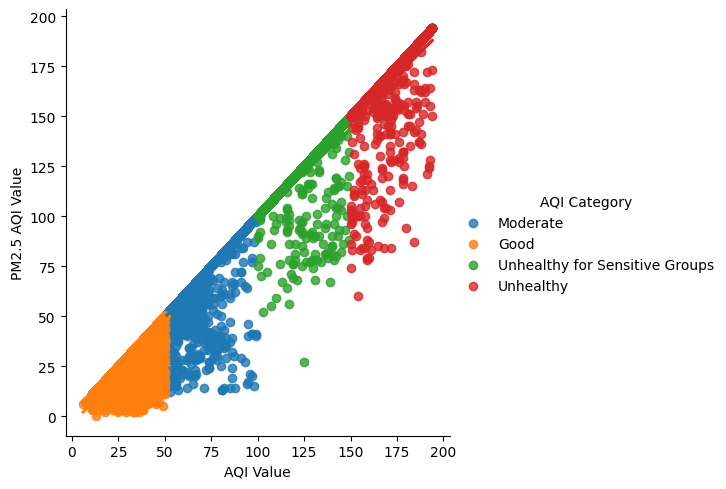

In [ ]:
sns.lmplot(data=data,y='PM2.5 AQI Value',x='AQI Value',hue="AQI Category");

In [ ]:
pip install chart-studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.3 MB/s eta 0:00:00


In [ ]:
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

In [ ]:
RU = data[(data['Country'] == 'Russian Federation')].copy()
RU = RU.dropna()

In [ ]:
latRU = RU['lat'].tolist()
lonRU = RU['lng'].tolist()
locations = list(zip(latRU, lonRU))

Moscow = folium.Map(location=[55.751244,37.618423], zoom_start=8.5)
FastMarkerCluster(data=locations).add_to(Moscow)
Moscow

Так как мы избавлялись от выбросов, то стоит перезаписать датасет.

In [ ]:
data.to_csv('prep_data.csv', index=False)



---



---



---

